In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.8 MB/s 


In [ ]:
import pandas as pd 
import numpy as np
from scipy.stats import sem
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from collections import Counter
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTEENN, SMOTETomek  
from imblearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef, make_scorer)
from nltk.util import bigrams
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline, pad_both_ends

In [ ]:
import shap #for shap visualisations
shap.initjs()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/trainset.csv" "train.csv" # Import datasets 
!cp "/content/drive/My Drive/testset.csv" "test.csv"
!cp "/content/drive/My Drive/devset.csv" "dev.csv"

In [ ]:
dfs = []
dfn = []
le = LabelEncoder()
dfn = pd.read_csv("test.csv",parse_dates=['created_at'])
dfs.append(pd.read_csv("train.csv",parse_dates=['created_at']))
dfs.append(pd.read_csv("dev.csv",parse_dates=['created_at']))
dfs = pd.concat(dfs, axis=0,ignore_index=True)
d = pd.to_datetime({'year':[2020], 'month':[9], 'day':[30]},utc=True)
dfs['b'] = 1 # Create a dummy variable to compare which is higher between the users followers count and 1 to avoide dividing friends count by 0 to get infinity
dfs['friends_to_followers_ratio'] = dfs['friends_count']/dfs[['followers_count','b']].max(axis=1) 
dfs['Account_age'] = (d[0] - dfs['created_at']).dt.days
dfn['b'] = 1
dfn['friends_to_followers_ratio'] = dfn['friends_count']/dfn[['followers_count','b']].max(axis=1)
dfn['Account_age'] = (d[0] - dfn['created_at']).dt.days 
dfs = dfs.replace([np.inf, -np.inf], np.nan)
dfn = dfn.replace([np.inf, -np.inf], np.nan)
dfs = dfs.replace(np.nan, 0)#replace all missing values with 0
dfn = dfn.replace(np.nan, 0)#replace all missing values with 0
dfs['verified'] = le.fit_transform(dfs['verified'])
dfn['verified'] = le.fit_transform(dfn['verified'])
x_train = dfs
x_test = dfn
x_tr = dfs['verified']
x_tt = dfn['verified']
y_train = x_train['label']
y_test = x_test['label']
x_train = x_train.drop(columns=['Account_age','verified','geo_enabled','b','tweet','id_str', 'ID', 'screen_name', 'name', 'location', 'profile_location', 'description', 'default_profile_image', 'default_profile', 'has_extended_profile', 'protected', 'created_at', 'utc_offset', 'url', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile','is_translator','profile_background_color','is_translation_enabled','time_zone', 'profile_image_url_https', 'profile_use_background_image', 'profile_sidebar_border_color','profile_text_color', 'contributors_enabled', 'lang', 'profile_image_url', 'profile_link_color','profile_sidebar_fill_color', 'entities','label']) #drop all columns of features not needed for my model
x_test = x_test.drop(columns=['Account_age','verified','geo_enabled','b', 'tweet','id_str', 'ID', 'screen_name', 'name', 'location', 'profile_location', 'description', 'default_profile_image', 'default_profile', 'has_extended_profile', 'protected', 'created_at', 'utc_offset', 'url', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile','is_translator','profile_background_color','is_translation_enabled','time_zone', 'profile_image_url_https', 'profile_use_background_image', 'profile_sidebar_border_color','profile_text_color', 'contributors_enabled', 'lang', 'profile_image_url', 'profile_link_color','profile_sidebar_fill_color', 'entities','label'])

In [ ]:
dfs['screen_name'] = dfs['screen_name'].str.rstrip() 
dfn['screen_name'] = dfn['screen_name'].str.rstrip()
TwitH = dfs['screen_name']
train, vocab = padded_everygram_pipeline(2, TwitH)
lm = MLE(2)
lm.fit(train, vocab)
Twit_tr = dfs[['Account_age','verified','followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count','friends_to_followers_ratio']]
Twit_tt = dfn[['Account_age','verified','followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count','friends_to_followers_ratio']]
Twit_tr['default_profile'] = le.fit_transform(dfs['default_profile'])#binary
Twit_tr['profile_use_background_image'] = le.fit_transform(dfs['profile_use_background_image'])#binary
Twit_tr['screen_name_num']= dfs['screen_name'].str.count('\d') #count of numbers in screename
Twit_tr['screen_name_length'] = dfs['screen_name'].str.len() #len of screen name
Twit_tr['name_length'] = dfs['name'].str.len() #len of name
Twit_tr['name_num']= dfs['name'].str.count('\d') #count of numbers in name
Twit_tr['description_len'] = dfs['description'].str.len()#len of description
Twit_tr['screen_perp'] = dfs['screen_name'].map(lambda x : lm.perplexity(bigrams(pad_both_ends(x, n=2)))) #
Twit_tr['tweet_rate'] = dfs['statuses_count']/dfs['Account_age']
Twit_tr['friend_rate'] = dfs['friends_count']/dfs['Account_age']
Twit_tr['following_rate'] = dfs['followers_count']/dfs['Account_age']
Twit_tr['favourites_rate'] = dfs['favourites_count']/dfs['Account_age']
Twit_tr['listed_rate'] = dfs['listed_count']/dfs['Account_age']
Twit_tr = Twit_tr.drop(columns=['verified','Account_age'])
Twit_tt['default_profile'] = le.fit_transform(dfn['default_profile'])#same for test dataset
Twit_tt['profile_use_background_image'] = le.fit_transform(dfn['profile_use_background_image'])
Twit_tt['screen_name_num']= dfn['screen_name'].str.count('\d') 
Twit_tt['screen_name_length'] = dfn['screen_name'].str.len() 
Twit_tt['name_length'] = dfn['name'].str.len() 
Twit_tt['name_num']= dfn['name'].str.count('\d') 
Twit_tt['description_len'] = dfn['description'].str.len()
Twit_tt['screen_perp'] = dfn['screen_name'].map(lambda x : lm.perplexity(bigrams(pad_both_ends(x, n=2))))
Twit_tt['tweet_rate'] = dfn['statuses_count']/dfn['Account_age']
Twit_tt['friend_rate'] = dfn['friends_count']/dfn['Account_age']
Twit_tt['following_rate'] = dfn['followers_count']/dfn['Account_age']
Twit_tt['favourites_rate'] = dfn['favourites_count']/dfn['Account_age']
Twit_tt['listed_rate'] = dfn['listed_count']/dfn['Account_age']
Twit_tt = Twit_tt.drop(columns=['verified','Account_age'])
Twit_tt = Twit_tt.replace([np.inf, -np.inf], np.nan)
Twit_tt = Twit_tt.replace(np.nan, 0) #for the cases where screen likelihood is infinity in test set for unseen examples
x_trains = StandardScaler().fit_transform(Twit_tr) #Scale data excluding verified boolean features
x_tests = StandardScaler().fit_transform(Twit_tt)
x_tr = pd.concat([pd.DataFrame(x_trains),x_tr],axis=1) # combine scaled feature with "verified" feature
x_tt = pd.concat([pd.DataFrame(x_tests),x_tt], axis=1)
x_tr.columns=['followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count',	'friends_to_followers_ratio',	'default_profile',	'profile_use_background_image',	'screen_name_num',	'screen_name_length',	'name_length',	'name_num',	'description_len',	'screen_perp',	'tweet_rate',	'friend_rate',	'following_rate',	'favourites_rate',	'listed_rate','verified']
x_tt.columns=['followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count',	'friends_to_followers_ratio',	'default_profile',	'profile_use_background_image',	'screen_name_num',	'screen_name_length',	'name_length',	'name_num',	'description_len',	'screen_perp',	'tweet_rate',	'friend_rate',	'following_rate',	'favourites_rate',	'listed_rate','verified']

To calculate Yang et al features as a benchmark for my model


In [ ]:
x_trains = StandardScaler().fit_transform(x_train) #Scale data excluding verified boolean features
x_tests = StandardScaler().fit_transform(x_test)
x_tr = pd.concat([pd.DataFrame(x_trains),x_tr],axis=1) # combine scaled feature with "verified" feature
x_tt = pd.concat([pd.DataFrame(x_tests),x_tt], axis=1)
x_tr.columns=['followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count',	'mentions',	'hashtags',	'urls',	'retweets',	'subjectivity_score',	'compound',	'neg',	'neu',	'pos',	'Text_sim',	'friends_to_followers_ratio','verified']
x_tt.columns=['followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count',	'mentions',	'hashtags',	'urls',	'retweets',	'subjectivity_score',	'compound',	'neg',	'neu',	'pos',	'Text_sim',	'friends_to_followers_ratio','verified']

In [ ]:
class_H = dfs[dfs['label'] == 0] #To visualise dataset features
class_SS = dfs[dfs['label'] == 1]
data1 = class_H['friends_to_followers_ratio']
data2 = class_SS['friends_to_followers_ratio']
plt.figure(figsize=(8,6))
plt.hist(data1, bins=10, alpha=0.3, label="Human")
plt.hist(data2, bins=10, alpha=0.3, label="Bot")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Comparison of url ratio of Bots and Humans")
plt.legend(loc='upper right')

In [ ]:
dfs.boxplot(column=['urls'], by="label",figsize=(10,8)) 

In [ ]:
lr_param = { #parameters to gridsearch
    'C': [0.1, 1, 10, 100, 1000],
    'penalty' : ['l2','l1']

}

SVM_param = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf','linear','sigmoid']
}

rf_param = {
    'n_estimators': [100,150,200],
    'criterion' :['entropy','log_loss'],
    'max_depth' : [10,12,14,16,20],
    'max_features': ['sqrt','log2'],
    'bootstrap' : [True, False]
}

xgb_param = {
    'min_child_weight': [5, 7, 10],
    'gamma': [0.5, 1],
    'subsample': [0.6, 1.0],
    'max_depth': [6,8,10,12,14]
}

In [ ]:
grid1 = model_selection.GridSearchCV(LogisticRegression(), param_grid=lr_param, scoring='precision',cv=5)
grid1.fit(x_tr, y_train)
best_model1 = grid1.best_estimator_
best_model1.fit(x_tr, y_train)

In [ ]:
y_pred1 = best_model1.predict(x_tt)#print classification report
clf = classification_report(y_pred1, y_test)
print(clf)

In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred1)) #Print the Matthew Correlation coefficient for Model 1
print('\nf1:',f1_score(y_test, y_pred1)) #Print the F1 score for Model 1
print('\nprecision:',precision_score(y_test, y_pred1)) #Print the Precision for Model 1
print('\nrecall:',recall_score(y_test, y_pred1)) #Print the Recall value for Model 1
print('\nroc:',roc_auc_score(y_test, y_pred1)) #Print the ROC score for Model 1
print('\naccuracy:',accuracy_score(y_test, y_pred1)) #Print the Accuracy  for Model 1 

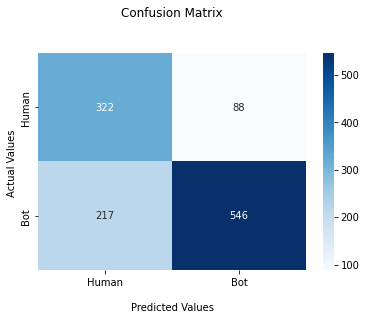

In [ ]:
cf_matrix = confusion_matrix(y_pred1, y_test) # Create a confusion matrix of predicted and actual values for test set of model 1
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=".0f") #create a visualisation of matris using sns

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Human','Bot'])#Relabel 0
ax.yaxis.set_ticklabels(['Human','Bot'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
grid2 = model_selection.GridSearchCV(SVC() , param_grid=SVM_param , scoring='precision',cv=5)
grid2.fit(x_tr, y_train)
best_model2 = grid1.best_estimator_
best_model2.fit(x_tr, y_train)

In [ ]:
y_pred2 = best_model2.predict(x_tt)
clf = classification_report(y_pred2, y_test)
print(clf)

In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred2)) #Print the Matthew Correlation coefficient for Model 2
print('\nf1:',f1_score(y_test, y_pred2)) #Print the F1 score for Model 2
print('\nprecision:',precision_score(y_test, y_pred2)) #Print the Precision for Model 2
print('\nrecall:',recall_score(y_test, y_pred2)) #Print the Recall value for Model 2
print('\nroc:',roc_auc_score(y_test, y_pred2)) #Print the ROC score for Model 2
print('\naccuracy:',accuracy_score(y_test, y_pred2)) #Print the Accuracy  for Model 2

In [ ]:
cf_matrix = confusion_matrix(y_pred2, y_test) # Create a confusion matrix of predicted and actual values for test set of model 2
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=".0f") #create a visualisation of matris using sns

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Human','Bot'])#Relabel 0
ax.yaxis.set_ticklabels(['Human','Bot'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
grid3 = model_selection.GridSearchCV(RandomForestClassifier(), param_grid = rf_param, scoring='precision', cv=5) #Apply gridsearch for Random Forest Classifier 
grid3.fit(x_tr, y_train)
best_model3 = grid3.best_estimator_ #Provide the model with the best parameters
best_model3.fit(x_tr, y_train)#Train the model with best hyperameters on training data

In [ ]:
best_model3

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       max_features='sqrt', n_estimators=150)

In [ ]:
y_pred3 = best_model3.predict(x_tt)
clf3 = classification_report(y_pred3, y_test)
print(clf3)

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       425
           1       0.96      0.81      0.88       748

    accuracy                           0.86      1173
   macro avg       0.85      0.87      0.85      1173
weighted avg       0.88      0.86      0.86      1173



In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred3)) #Print the Matthew Correlation coefficient for Model 3
print('\nf1:',f1_score(y_test, y_pred3)) #Print the F1 score for Model 3
print('\nprecision:',precision_score(y_test, y_pred3)) #Print the Precision for Model 3
print('\nrecall:',recall_score(y_test, y_pred3)) #Print the Recall value for Model 3
print('\nroc:',roc_auc_score(y_test, y_pred3)) #Print the ROC score for Model 3
print('\naccuracy:',accuracy_score(y_test, y_pred3)) #Print the Accuracy  for Model 3


matthews_corrcoef: 0.7214217319437183

f1: 0.8784370477568741

precision: 0.8114973262032086

recall: 0.9574132492113565

roc: 0.8479088509507617

accuracy: 0.8567774936061381


 99%|===================| 2333/2346 [01:13<00:00]       

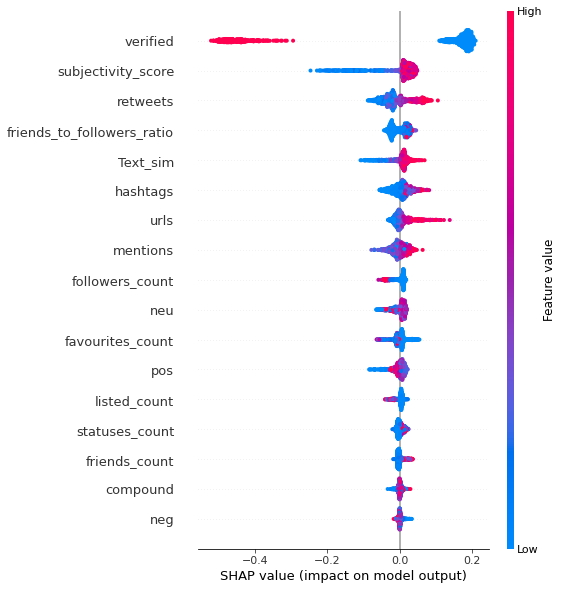

In [ ]:
explainer = shap.TreeExplainer(best_model3,x_tt) 
shap_values = explainer.shap_values(x_tt) 
shap.summary_plot(shap_values[1], x_tt) #Provide shap model explainer 

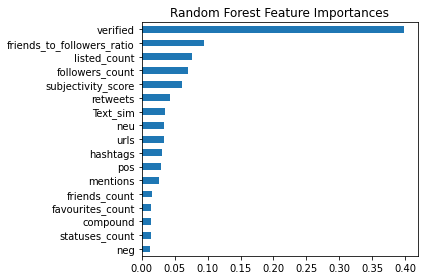

In [ ]:
feature_scores = pd.Series(best_model3.feature_importances_, index=x_tr.columns).sort_values(ascending=True)
ax = feature_scores.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

In [ ]:
cf_matrix = confusion_matrix(y_pred3, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=".0f")

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Human','Bot'])
ax.yaxis.set_ticklabels(['Human','Bot'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
grid4 = model_selection.GridSearchCV(XGBClassifier(objective ='binary:logistic'),param_grid = xgb_param, scoring='precision_weighted', cv=5)
grid4.fit(x_train, y_train)
best_model4 = grid4.best_estimator_
best_model4.fit(x_tr, y_train)

In [ ]:
best_model4

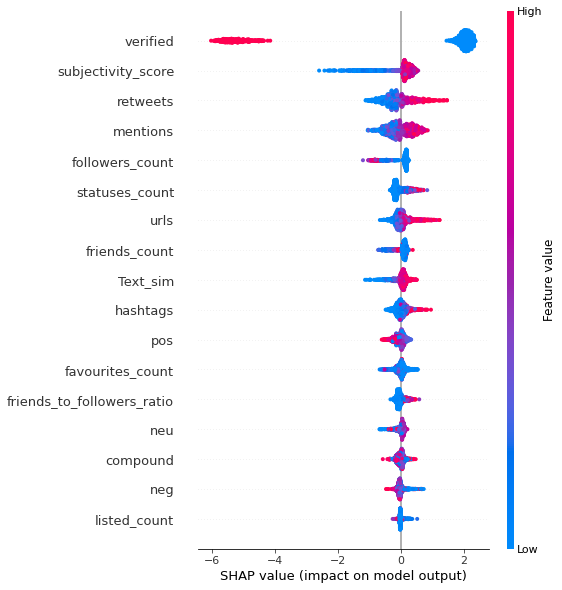

In [ ]:
explainer = shap.TreeExplainer(best_model4,x_tt) 
shap_values = explainer.shap_values(x_tt) 
shap.summary_plot(shap_values, x_tt) #Provide shap model explainer 

In [ ]:
y_pred4 = best_model4.predict(x_tt)
clf4 = classification_report(y_pred4, y_test)
print(clf4)

In [ ]:
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred4)) #Print the Matthew Correlation coefficient for Model 4
print('\nf1:',f1_score(y_test, y_pred4)) #Print the F1 score for Model 4
print('\nprecision:',precision_score(y_test, y_pred4)) #Print the Precision for Model 4
print('\nrecall:',recall_score(y_test, y_pred4)) #Print the Recall value for Model 4
print('\nroc:',roc_auc_score(y_test, y_pred4)) #Print the ROC score for Model 4
print('\naccuracy:',accuracy_score(y_test, y_pred4)) #Print the Accuracy  for Model 4

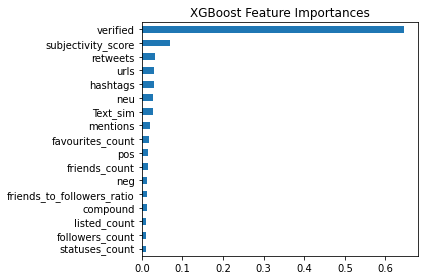

In [ ]:
feature_scores = pd.Series(best_model4.feature_importances_, index=x_tr.columns).sort_values(ascending=True)
ax = feature_scores.plot.barh()
ax.set_title("XGBoost Feature Importances")
ax.figure.tight_layout()

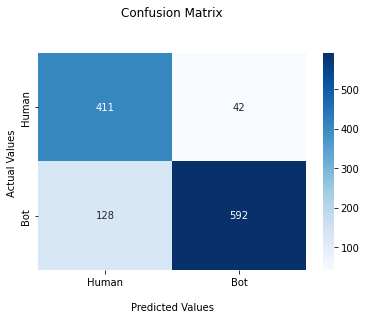

In [ ]:
cf_matrix = confusion_matrix(y_pred4, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt=".0f")

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Human','Bot'])
ax.yaxis.set_ticklabels(['Human','Bot'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
smt = SMOTEENN(random_state=10)#test for smote application
smt1 = SMOTENC(random_state=10, categorical_features=[16])
smt2 = SMOTE(random_state=10)
smt3 = SMOTETomek(random_state=10)
clf_rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20, max_features='sqrt') #best models found in our search
clf_xgb = XGBClassifier(gamma=0.5, max_depth=10, min_child_weight=10, subsample=1.0)
pipe1 = Pipeline([('smt', smt), ('rf', clf_rf)])
pipe11 = Pipeline([('smt', smt1), ('rf', clf_rf)])# To introduce smote within a pipeline to not introduce bias
pipe12 = Pipeline([('smt', smt2), ('rf', clf_rf)])
pipe13 = Pipeline([('smt', smt3), ('rf', clf_rf)])
pipe2 = Pipeline([('smt', smt), ('xgb', clf_xgb)])
pipe21 = Pipeline([('smt', smt1), ('xgb', clf_xgb)])
pipe22 = Pipeline([('smt', smt2), ('xgb', clf_xgb)])
pipe23 = Pipeline([('smt', smt3), ('xgb', clf_xgb)])
x = pd.concat([x_tr,x_tt])
y = pd.concat([y_train,y_test])
rf = RandomForestClassifier(n_estimators=100) #yang random forest model

In [ ]:
scoring = {'ACC': 'accuracy', 'recall': 'recall', 'f1': 'f1', 'ROC': 'roc_auc', 'prec': 'precision', 'MCC': make_scorer(matthews_corrcoef)}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=20)
score1 = cross_validate(clf_rf, x, y, scoring=scoring, cv=cv, return_estimator=True)
score2 = cross_validate(clf_xgb, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score3 = cross_validate(rf, x, y, scoring=scoring, cv=cv, return_estimator=True)

In [ ]:
df = pd.DataFrame(score1)
df.mean()

In [ ]:
df1 = pd.DataFrame(score2)
df1.mean()

In [ ]:
df2 = pd.DataFrame(score3)
df2.mean()

In [ ]:
scoring = {'ACC': 'accuracy', 'recall': 'recall', 'f1': 'f1', 'ROC': 'roc_auc', 'prec': 'precision', 'MCC': make_scorer(matthews_corrcoef)}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=30)
# score1 = cross_validate(pipe1, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score2 = cross_validate(pipe11, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score3 = cross_validate(pipe12, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score4 = cross_validate(pipe13, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score5 = cross_validate(pipe2, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score6 = cross_validate(pipe21, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score7 = cross_validate(pipe22, x, y, scoring=scoring, cv=cv, return_estimator=True)
# score8 = cross_validate(pipe23, x, y, scoring=scoring, cv=cv, return_estimator=True)

In [ ]:
df = pd.DataFrame(score1)
df.mean()

In [ ]:
df1 = pd.DataFrame(score2)
df1.mean()

In [ ]:
df2 = pd.DataFrame(score3)
df2.mean()

In [ ]:
df3 = pd.DataFrame(score4)
df3.mean()

In [ ]:
df4 = pd.DataFrame(score5)
df4.mean()

In [ ]:
df5 = pd.DataFrame(score6)
df5.mean()

In [ ]:
df6 = pd.DataFrame(score7)
df6.mean()

In [ ]:
df7 = pd.DataFrame(score8)
df7.mean()